In [2]:
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from __future__ import unicode_literals
from collections import Counter
from math import *
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.ensemble import BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.svm import SVR
import eli5
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report, f1_score,accuracy_score ,confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
import matplotlib.gridspec as gridspec
from sklearn.impute import KNNImputer
import seaborn as sns
import warnings
from warnings import simplefilter
import ast
simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [4]:
train_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/test.csv")
store_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/store.csv")

### Archivos:
* **train.csv** - datos histórico incluyendo Sales
* **test.csv** - datos histórico excluyendo Sales
* **sample_submission.csv** - ejemplo del formato que debe tener el submission a Kaggle 
* **store.csv** - información suplementaria sobre las tiendas

### Campos:
Descripción de los campos menos descriptivos

* **Id** - Id único para cada par de Store y Date
* **Store** - Id unívoco para cada tienda
* **Sales** - ventas para cada día dado. Variable target
* **Customers** - cantidad de clientes para un día dado
* **Open** - variable binaria que indica si la tienda esta abierta o no: 0 = cerrada, 1 = abierta
* **StateHoliday** - indica si se trata de un feriado estatal. Normalmente las tienfas estan cerradas durante los feriados: a = feriado, b = Pascuas, c = Navidad, 0 = ninguna. 
* **SchoolHoliday** - indica si la dupla Tienda, fecha es afectada por el cierre de las esceulas. 
* **StoreType** - diferentes modelos de tiendas: a, b, c, d
* **Assortment** - grado de provisionamiento: a = basic, b = extra, c = extended
* **CompetitionDistance** - distancia en metros a la tienda del competidor mas cercano. 
* **CompetitionOpenSince**[Month/Year] - año y mes en que abrió el competidor más cercano.
* **Promo** - indica si la tienda tiene una promoción ese día o no.
* **Promo2** - Promo2 indica si la tienda esta participa de promociones consecutivas: 0 = la tienda no participa, 1 = tienda participa
* **Promo2Since**[Year/Week] - indica la semana y año en la que la tienda comenzó a participar de Promo2
* **PromoInterval** - meses en los que comienza Promo2. Por ejemplo: "Feb,May,Aug,Nov" significa que la ronda de promociones comienza en Febrero, Mayo, Agosto y Noviembre. 

In [5]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [8]:
train_df["Date"] = pd.to_datetime(train_df["Date"])

train_df["Day"] = train_df["Date"].dt.day
train_df["Month"] = train_df["Date"].dt.month
train_df["Year"] = train_df["Date"].dt.year
train_df["Day_Name"] = train_df["Date"].dt.day_name()
#train_df.drop("Date",axis=1,inplace=True)

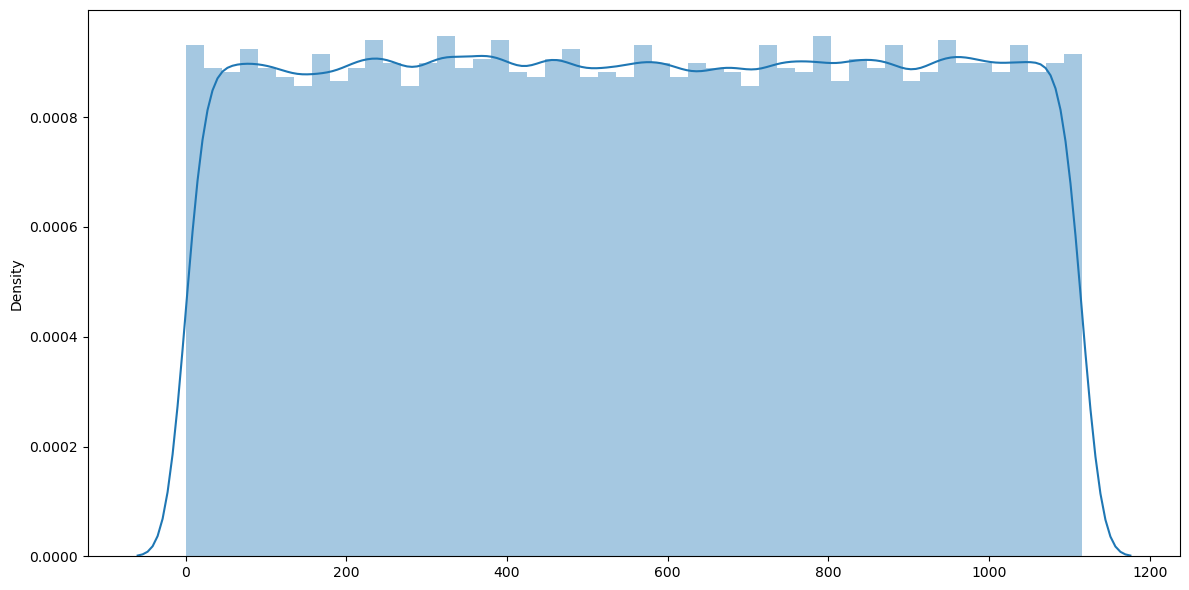

In [9]:
plt.figure(figsize=(12,6))
sns.distplot(x = train_df["Store"])
plt.tight_layout()

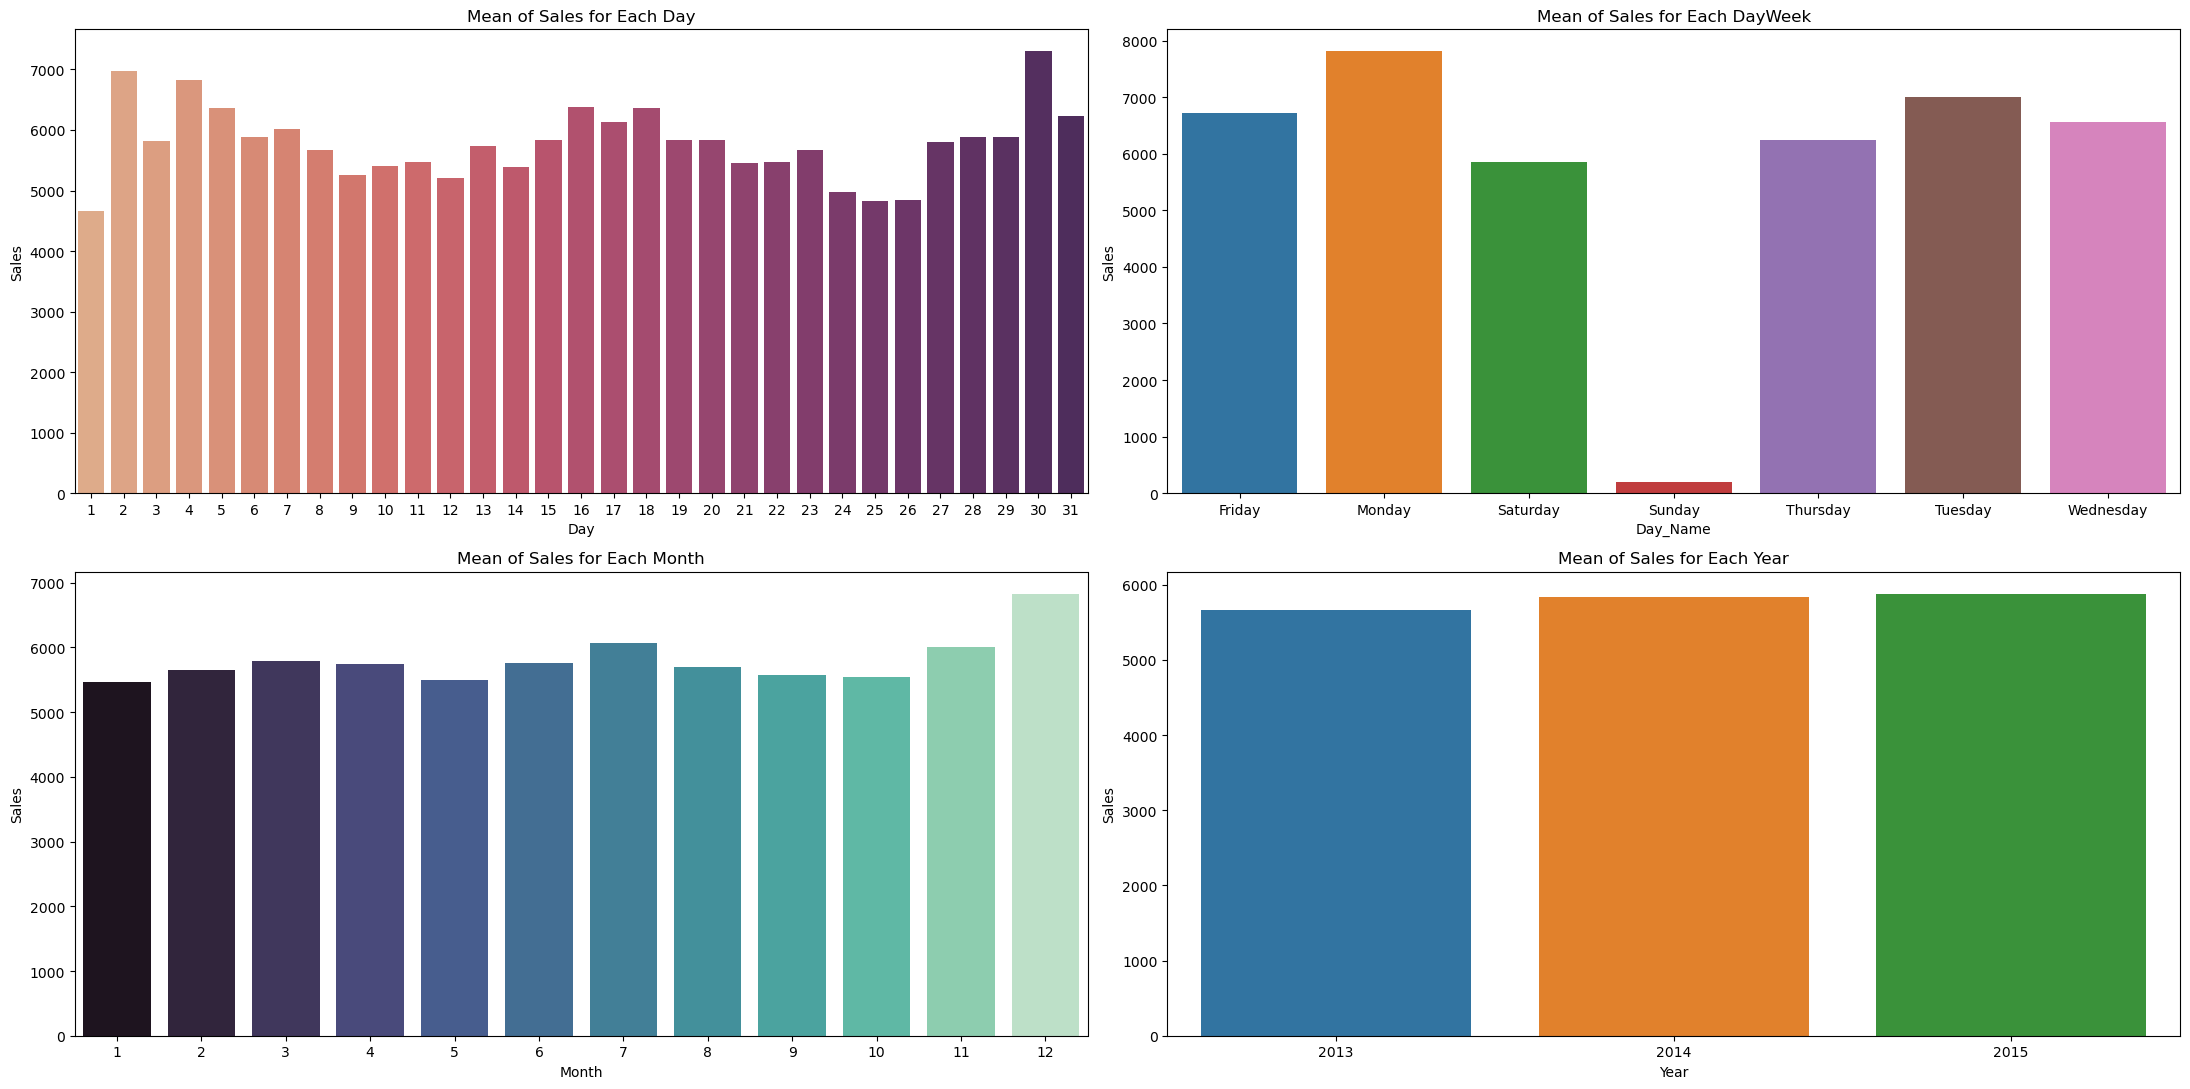

In [10]:
day_df = train_df.groupby("Day")["Sales"].mean().to_frame().reset_index()
day_name_df = train_df.groupby("Day_Name")["Sales"].mean().to_frame().reset_index()
month_df = train_df.groupby("Month")["Sales"].mean().to_frame().reset_index()
year_df = train_df.groupby("Year")["Sales"].mean().to_frame().reset_index()
fig , ax = plt.subplots(2,2,figsize = (22,11))
ax1 = sns.barplot(x=day_df["Day"],y=day_df["Sales"],ax=ax[0,0],palette="flare")
ax1.set_title("Mean of Sales for Each Day")
ax2 = sns.barplot(x=day_name_df["Day_Name"],y=day_name_df["Sales"],ax=ax[0,1])
ax2.set_title("Mean of Sales for Each DayWeek")
ax3 = sns.barplot(x=month_df["Month"],y=month_df["Sales"],ax=ax[1,0],palette="mako")
ax3.set_title("Mean of Sales for Each Month")
ax4 = sns.barplot(x=year_df["Year"],y=year_df["Sales"],ax=ax[1,1])
ax4.set_title("Mean of Sales for Each Year")
plt.tight_layout()

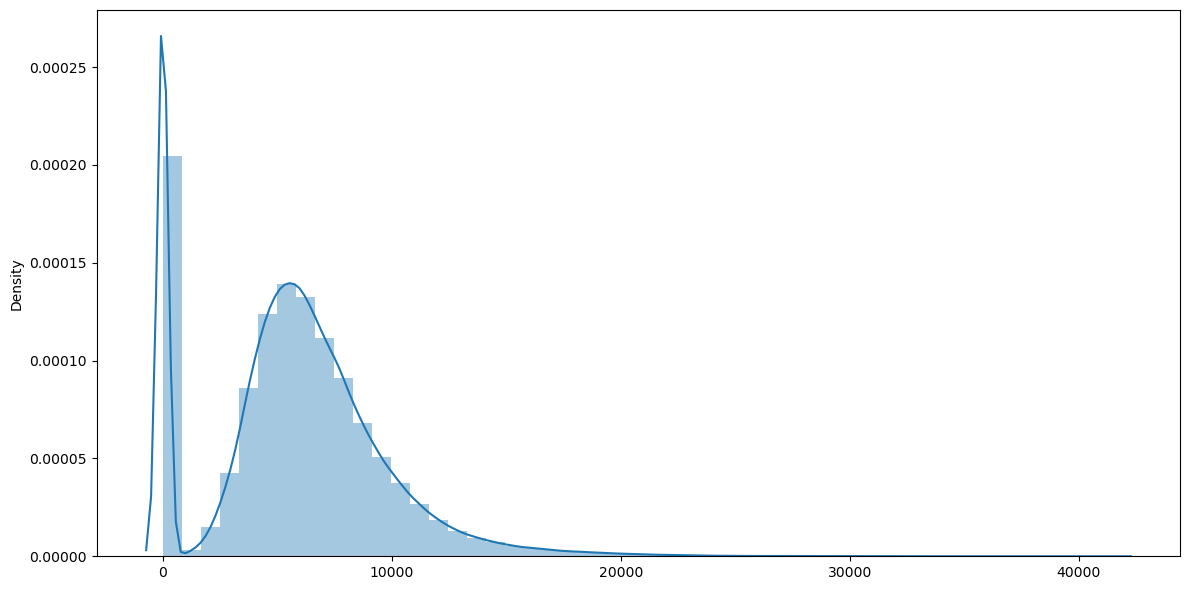

In [11]:
plt.figure(figsize=(12,6))
sns.distplot(x = train_df["Sales"])
plt.tight_layout()

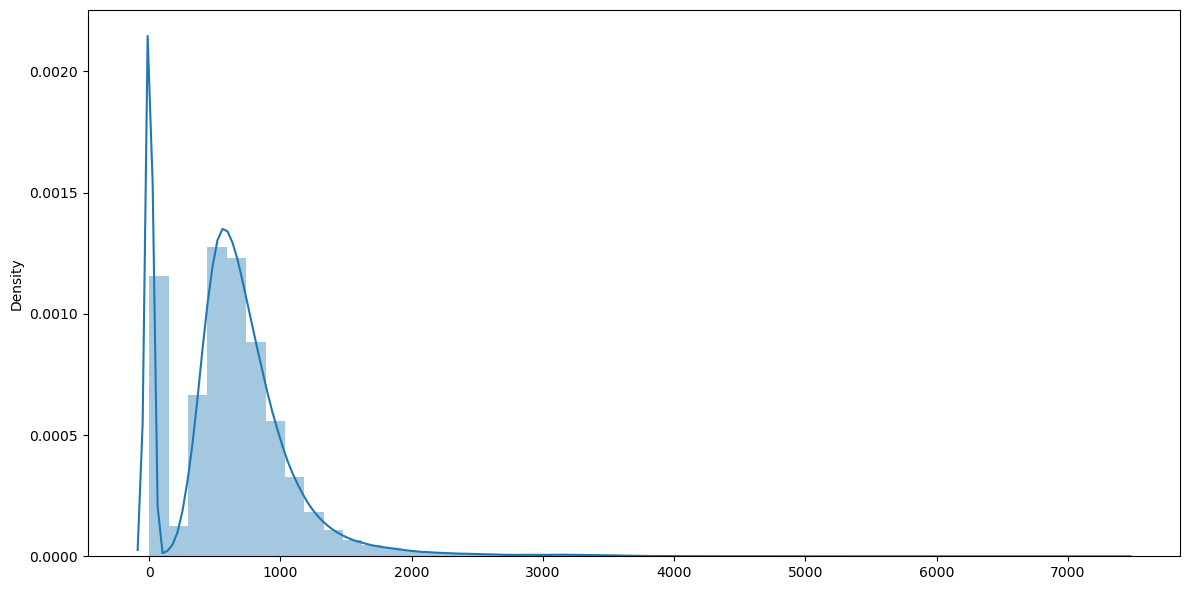

In [12]:
plt.figure(figsize=(12,6))
sns.distplot(x = train_df["Customers"])
plt.tight_layout()

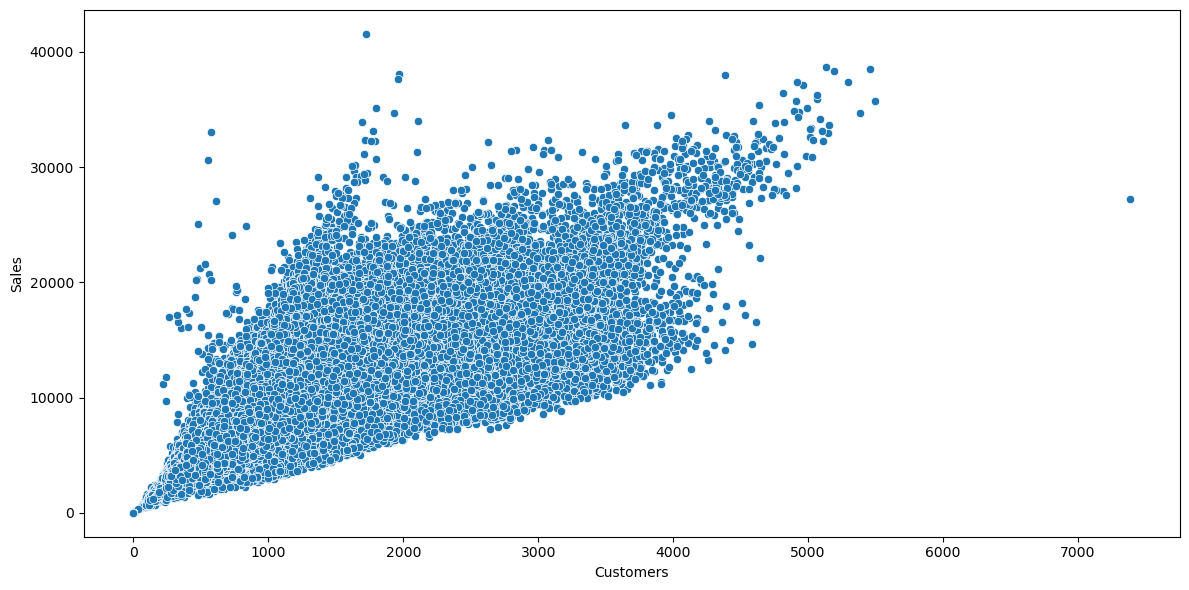

In [13]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = train_df["Customers"],y=train_df["Sales"])
plt.tight_layout()

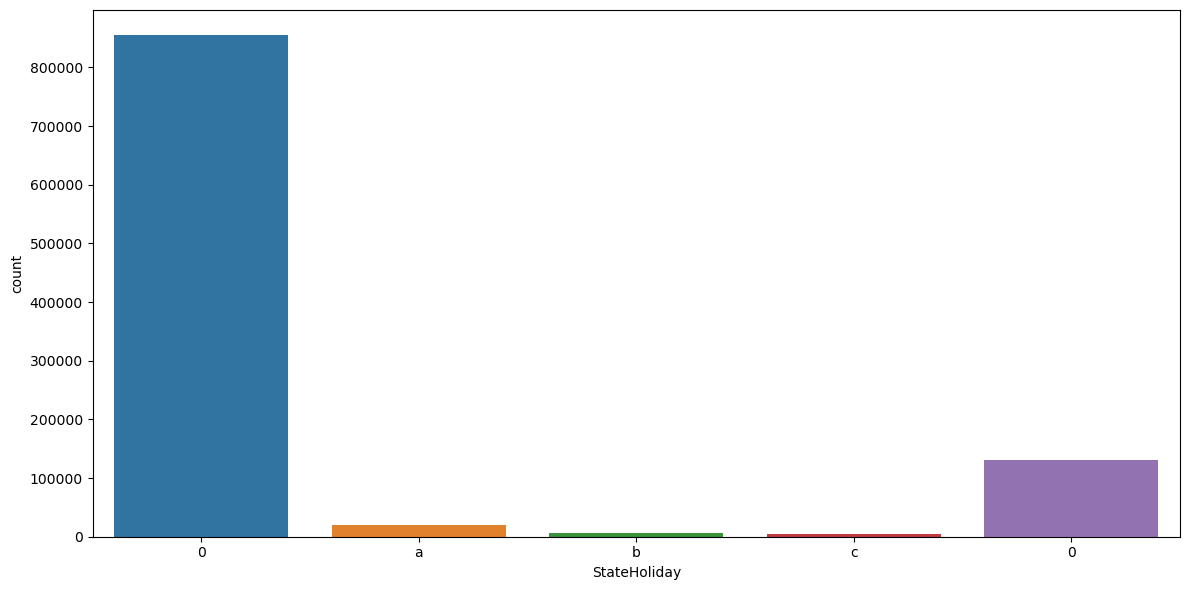

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(x = train_df["StateHoliday"])
plt.tight_layout()

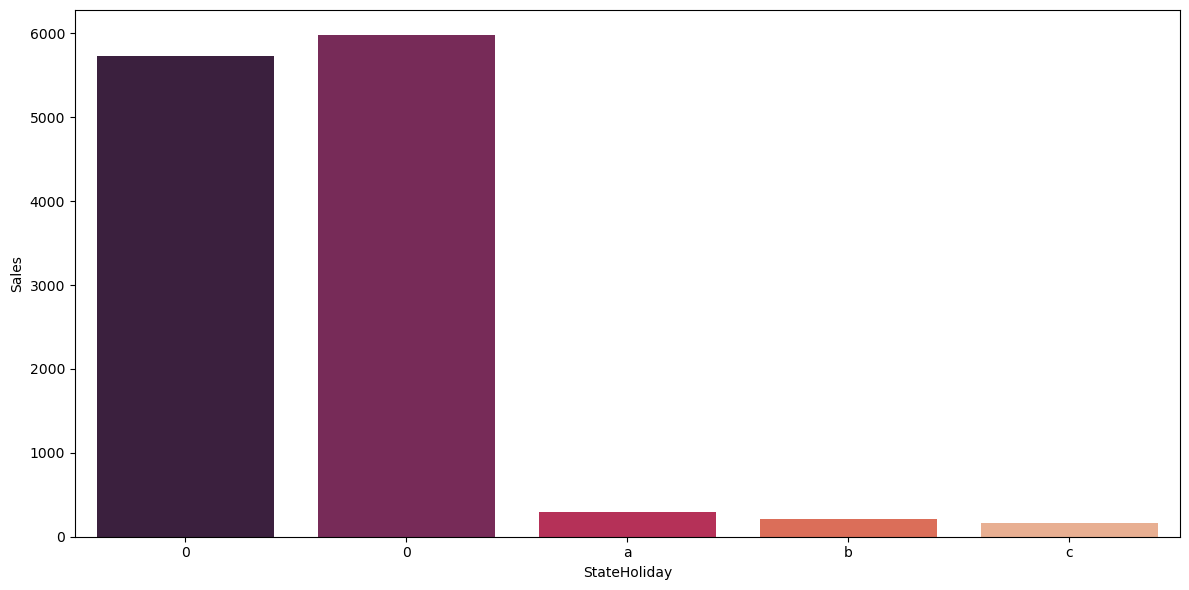

In [15]:
plt.figure(figsize=(12,6))
StateHoliday_df = train_df.groupby("StateHoliday")["Sales"].mean().to_frame().reset_index()
sns.barplot(x=StateHoliday_df["StateHoliday"],y=StateHoliday_df["Sales"],palette="rocket")
plt.tight_layout()

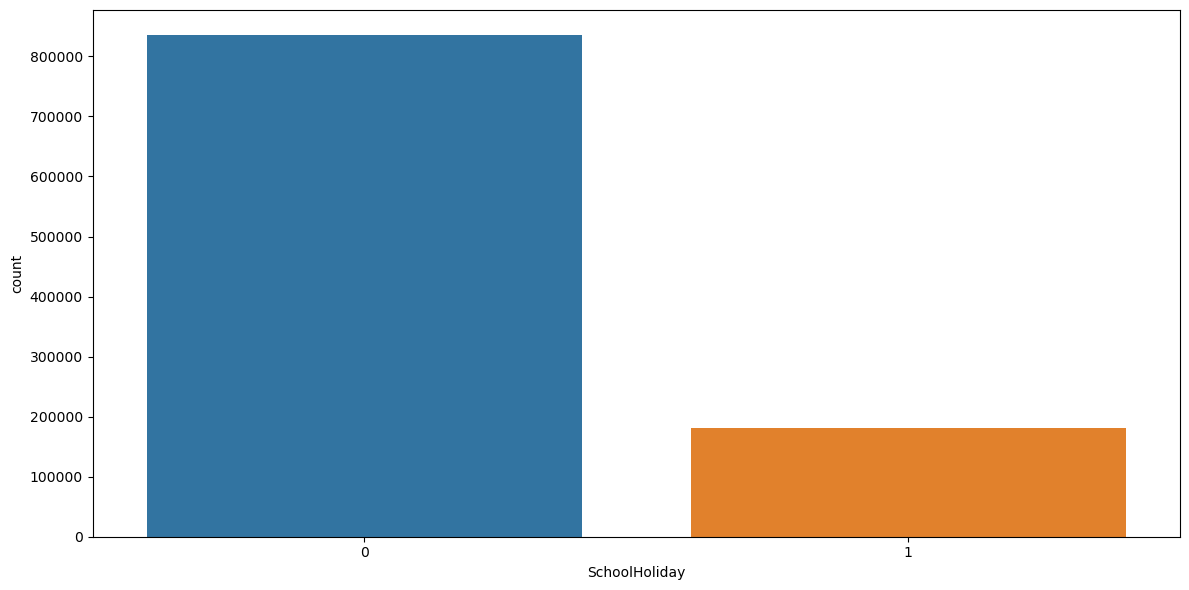

In [16]:
plt.figure(figsize=(12,6))
sns.countplot(x = train_df["SchoolHoliday"])
plt.tight_layout()

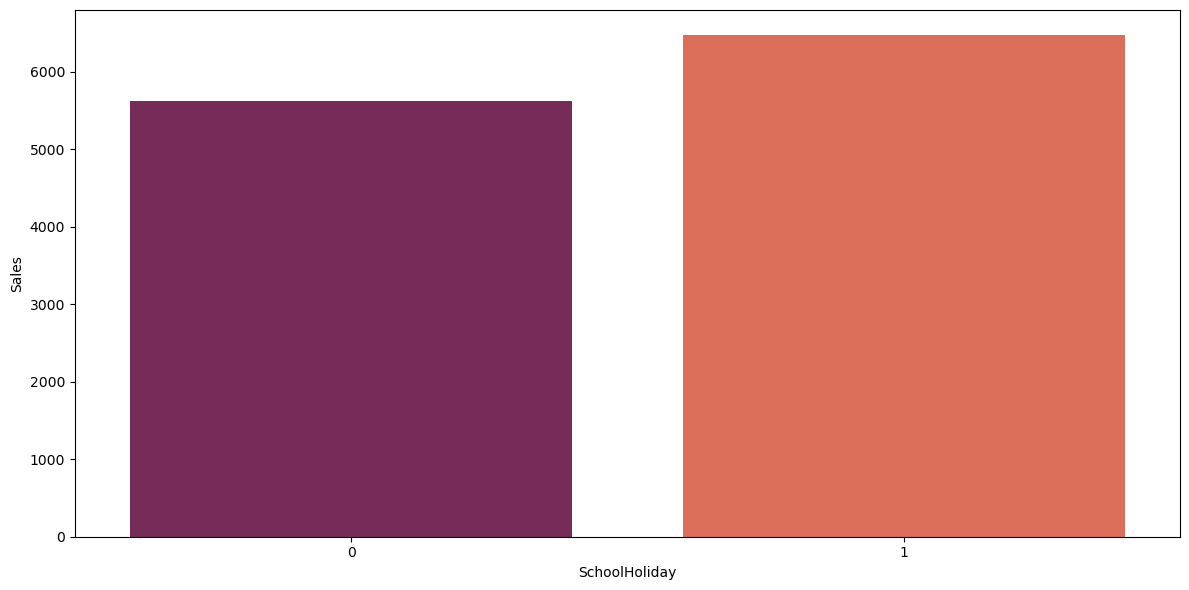

In [17]:
plt.figure(figsize=(12,6))
SchoolHoliday_df = train_df.groupby("SchoolHoliday")["Sales"].mean().to_frame().reset_index()
sns.barplot(x=SchoolHoliday_df["SchoolHoliday"],y=SchoolHoliday_df["Sales"],palette="rocket")
plt.tight_layout()

In [18]:
merged_df = train_df.merge(store_df, how='left', on='Store') #this is gonna be the merged training dataset
merged_test_df = test_df.merge(store_df, how='left', on='Store') #this is gonna be the merged testing dataset

<Axes: >

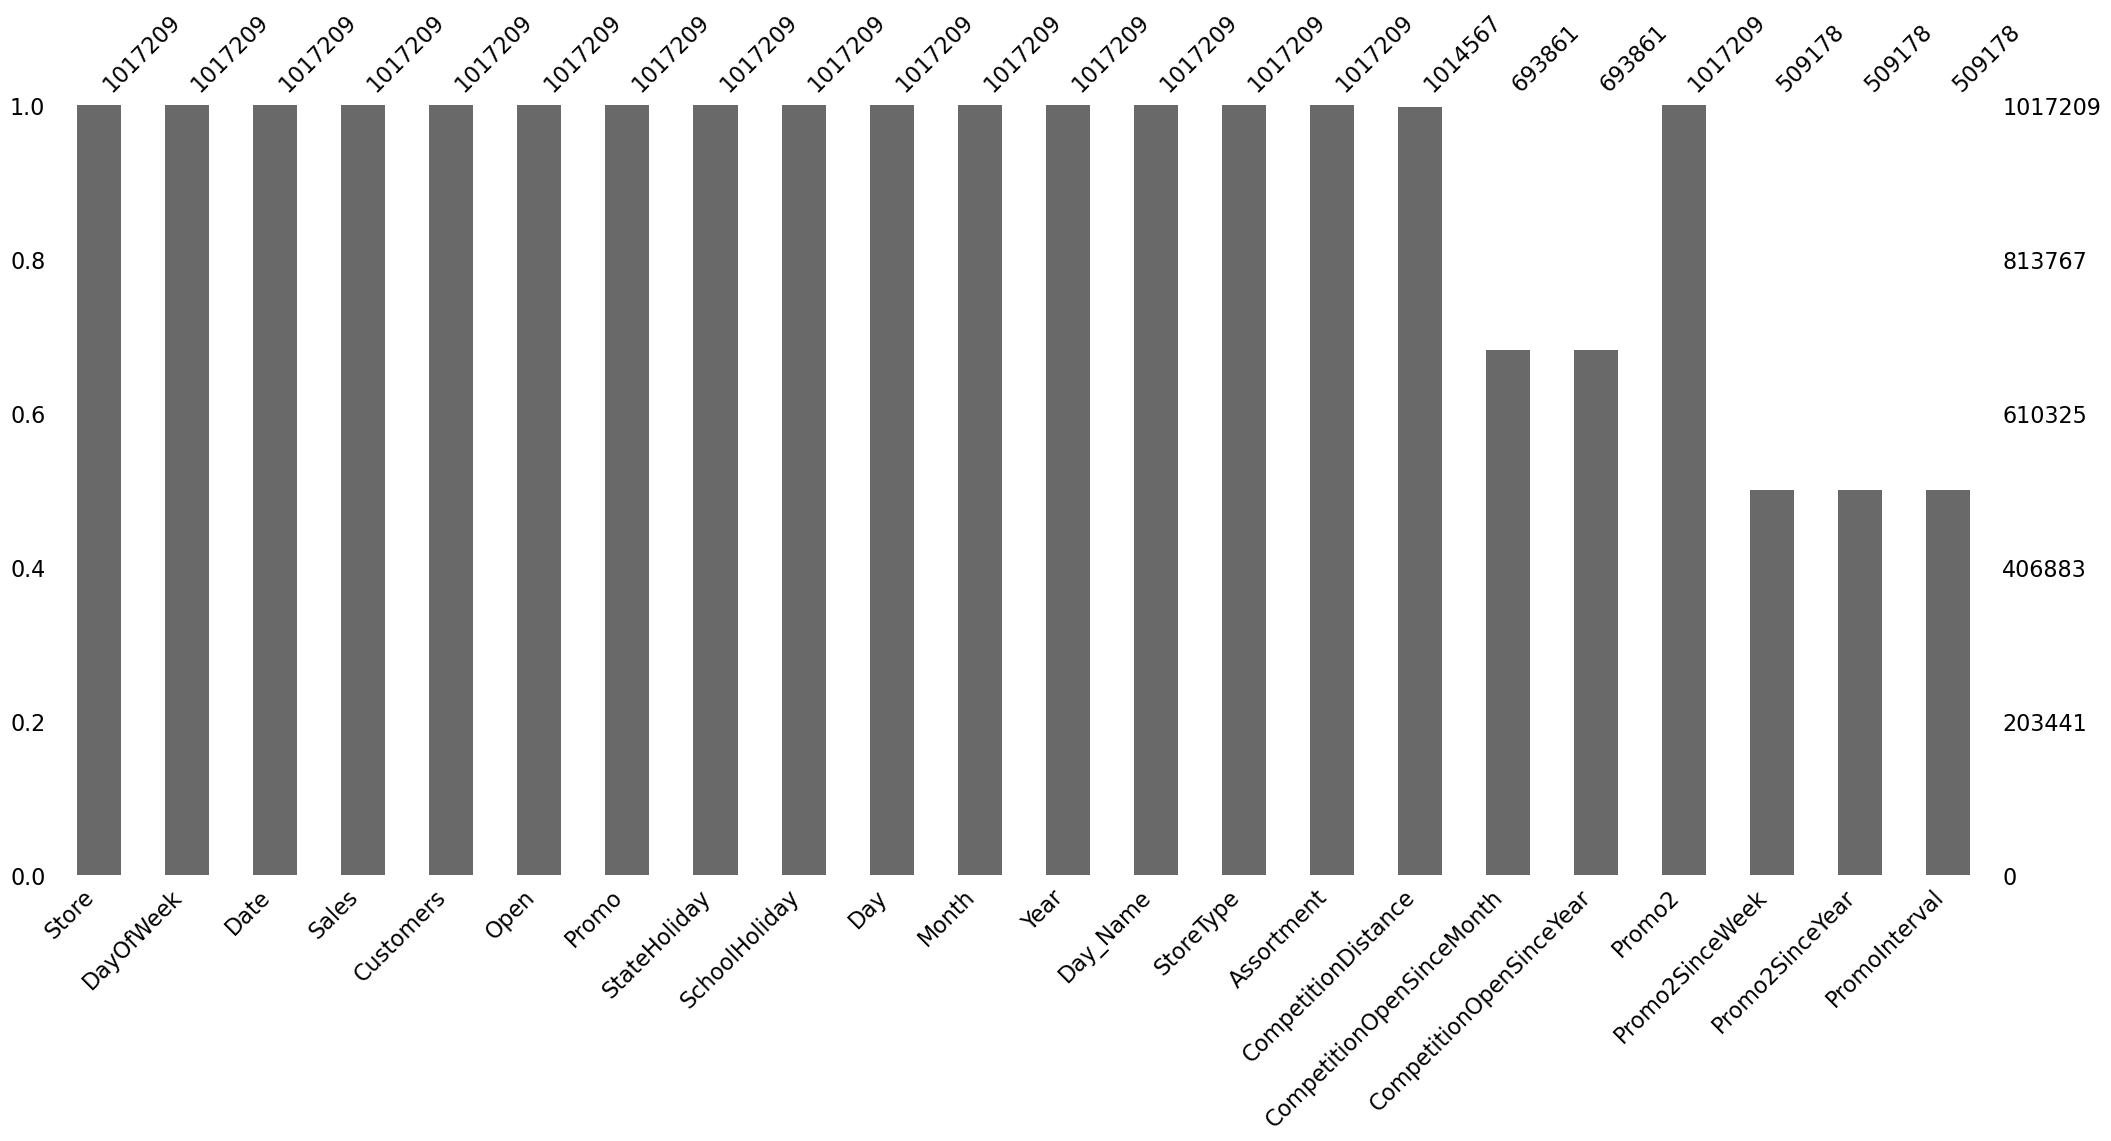

In [19]:
import missingno as msno

msno.bar(merged_df)

In [23]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

## Date


In [20]:
def split_date(df): #A helper function that takes a df and finds the Date column and extract the necessary info.
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week  #since we have day of the week already let's extrac the rest

In [21]:
split_date(merged_df)
split_date(merged_test_df)
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Day,Month,Year,Day_Name,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,31,7,2015,Friday,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31
1,2,5,2015-07-31,6064,625,1,1,0,1,31,7,2015,Friday,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31
2,3,5,2015-07-31,8314,821,1,1,0,1,31,7,2015,Friday,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,7,2015,Friday,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,31
4,5,5,2015-07-31,4822,559,1,1,0,1,31,7,2015,Friday,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,1,2013,Tuesday,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,1,2013,Tuesday,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,1,2013,Tuesday,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,1,2013,Tuesday,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,1


## Store Open/Closed

In [22]:
merged_df.groupby(by='Open')['Sales'].sum()

Open
0             0
1    5873180623
Name: Sales, dtype: int64

In [24]:
merged_df = merged_df[merged_df.Open == 1].copy() #Filtering only the rows where the store is open.
merged_df.groupby(by='Open')['Sales'].sum()

Open
1    5873180623
Name: Sales, dtype: int64

after filtering see there is no value as 'open==0'

## Competition

In [25]:
"""
This code creates a new feature called 'CompetitionOpen' in the input DataFrame, 
which represents the number of months that the competition for a given store has been open.

The function takes as input a DataFrame with columns 'Year', 'Month', 'CompetitionOpenSinceYear', and 'CompetitionOpenSinceMonth'. 
It first calculates the difference in months between the current year/month and the year/month when the competition opened. 
If the difference is negative (i.e., the competition has not yet opened), the function sets the value of 'CompetitionOpen' to 0.
Finally, it fills any missing values in 'CompetitionOpen' with 0.
"""    

def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [26]:
comp_months(merged_df)
comp_months(merged_test_df)

In [27]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
984298,2013-01-30,770.0,2013.0,5.0,0.0
715459,2013-09-28,6910.0,2005.0,4.0,101.0
440575,2014-06-02,580.0,2008.0,2.0,76.0
996285,2013-01-19,15340.0,2015.0,4.0,0.0
20404,2015-07-13,90.0,NaN,NaN,0.0
227427,2015-01-09,11540.0,NaN,NaN,0.0
881497,2013-05-02,32330.0,2014.0,3.0,0.0
837231,2013-06-11,20390.0,NaN,NaN,0.0
525666,2014-03-17,110.0,NaN,NaN,0.0
681219,2013-10-29,6400.0,2014.0,3.0,0.0


## Additional Promotion


In [28]:
"""

`promo_cols()` function creates new features related to promotions. It calculates how long the promotional offer has been open (in months) and 
creates a new feature 'Promo2Open'. It also creates a new feature 'IsPromo2Month' to check whether a new round of promotions was started 
in the current month.

`check_promo_month(row)` is a helper function used by `promo_cols()` function to check whether a new round of promotions was started in the current month. 
It takes a row as an input and returns 1 if a new round of promotions was started in the current month, otherwise 0. 
It uses the 'PromoInterval' column to get the months when the promotions are active and checks whether the current month is in that list.

"""

# Code not important just understand what we are trying to find.


def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [29]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [30]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
766731,2013-08-13,1,2013.0,27.0,"Feb,May,Aug,Nov",1.377049,1
912830,2013-04-04,0,NaN,NaN,NaN,0.000000,0
241047,2014-12-27,1,2013.0,31.0,"Jan,Apr,Jul,Oct",16.819672,0
848792,2013-06-01,0,NaN,NaN,NaN,0.000000,0
1012998,2013-01-04,0,NaN,NaN,NaN,0.000000,0
72670,2015-05-27,1,2011.0,14.0,"Jan,Apr,Jul,Oct",49.836066,0
703584,2013-10-09,1,2014.0,10.0,"Mar,Jun,Sept,Dec",0.000000,0
73031,2015-05-27,0,NaN,NaN,NaN,0.000000,0
945985,2013-03-05,1,2012.0,22.0,"Feb,May,Aug,Nov",9.245902,0
897528,2013-04-18,1,2011.0,22.0,"Jan,Apr,Jul,Oct",22.622951,1


# Preparación de las variables objetivo y de entrenamiento

In [31]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Day', 'Month', 'Year', 'Day_Name',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'WeekOfYear',
       'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [32]:
# Selecting only the required columns which i think will be good for ML model.

input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [33]:
# This created a dataframe with only columns names from the list we created above.

inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()
inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,5,1,0,1,c,a,1270.0,82.0,31,7,2015,31,0,0.000000,0
1,2,5,1,0,1,a,a,570.0,92.0,31,7,2015,31,1,64.131148,1
2,3,5,1,0,1,a,a,14130.0,103.0,31,7,2015,31,1,51.901639,1
3,4,5,1,0,1,c,c,620.0,70.0,31,7,2015,31,0,0.000000,0
4,5,5,1,0,1,a,a,29910.0,3.0,31,7,2015,31,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,0,a,1,b,a,150.0,76.0,1,1,2013,1,0,0.000000,0
1016827,733,2,0,a,1,b,b,860.0,159.0,1,1,2013,1,0,0.000000,0
1016863,769,2,0,a,1,b,b,840.0,0.0,1,1,2013,1,1,1.213115,1
1017042,948,2,0,a,1,b,b,1430.0,0.0,1,1,2013,1,0,0.000000,0


In [34]:
# Similarly doing the same for the test dataset
test_inputs = merged_test_df[input_cols].copy()
test_inputs

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekOfYear,Promo2,Promo2Open,IsPromo2Month
0,1,4,1,0,0,c,a,1270.0,84.0,17,9,2015,38,0,0.000000,0
1,3,4,1,0,0,a,a,14130.0,105.0,17,9,2015,38,1,53.508197,0
2,7,4,1,0,0,a,c,24000.0,29.0,17,9,2015,38,0,0.000000,0
3,8,4,1,0,0,a,a,7520.0,11.0,17,9,2015,38,0,0.000000,0
4,9,4,1,0,0,a,c,2030.0,181.0,17,9,2015,38,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,6,0,0,0,a,a,1900.0,14.0,1,8,2015,31,1,24.000000,0
41084,1112,6,0,0,0,c,c,1880.0,112.0,1,8,2015,31,0,0.000000,0
41085,1113,6,0,0,0,a,c,9260.0,0.0,1,8,2015,31,0,0.000000,0
41086,1114,6,0,0,0,a,c,870.0,0.0,1,8,2015,31,0,0.000000,0


In [35]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

# Impute missing numerical data


In [36]:
inputs[numeric_cols]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
0,1,1,1,1270.0,82.0,0,0.000000,0,31,7,2015,31
1,2,1,1,570.0,92.0,1,64.131148,1,31,7,2015,31
2,3,1,1,14130.0,103.0,1,51.901639,1,31,7,2015,31
3,4,1,1,620.0,70.0,0,0.000000,0,31,7,2015,31
4,5,1,1,29910.0,3.0,0,0.000000,0,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,0,1,150.0,76.0,0,0.000000,0,1,1,2013,1
1016827,733,0,1,860.0,159.0,0,0.000000,0,1,1,2013,1
1016863,769,0,1,840.0,0.0,1,1.213115,1,1,1,2013,1
1017042,948,0,1,1430.0,0.0,0,0.000000,0,1,1,2013,1


In [37]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekOfYear                0
dtype: int64

In [38]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekOfYear              0
dtype: int64

In [39]:
max_distance = inputs.CompetitionDistance.max()
max_distance

75860.0

In [40]:
inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True) #Filling with 2X Highest value to indicate that the competition is non existent
test_inputs['CompetitionDistance'].fillna(max_distance*2, inplace=True)

In [42]:
inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

In [43]:
test_inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekOfYear             0
dtype: int64

# Escalar variables numericas

In [44]:
inputs[numeric_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
min,1.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,1.0,1.0,2013.0,1.0
max,1115.0,1.0,1.0,151720.0,1386.0,1.0,72.0,1.0,31.0,12.0,2015.0,52.0


In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(inputs[numeric_cols])

In [46]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [47]:
inputs[numeric_cols].describe().loc[['min','max']]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear
min,-1.732571,-0.897887,-0.489947,-0.539902,-0.643561,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812
max,1.729942,1.113726,2.041038,13.540960,20.617466,1.002635,3.105031,2.390776,1.746347,1.851502,1.502796,1.970371


# Encoding de variables categoricas

In [48]:
inputs[categorical_cols]

,DayOfWeek,StateHoliday,StoreType,Assortment
0,5,0,c,a
1,5,0,a,a
2,5,0,a,a
3,5,0,c,c
4,5,0,a,a
...,...,...,...,...
1016776,2,a,b,a
1016827,2,a,b,b
1016863,2,a,b,b
1017042,2,a,b,b


In [49]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(inputs[categorical_cols].astype(str)) #This will handle unknown categories as separate one while Encoding values

In [50]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols).astype(str))
encoded_cols

['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [52]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols].astype(str)) #merging the encoded columns onto out inputs dataset
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols].astype(str))
inputs[encoded_cols]

,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [53]:
# Since i was using a list of columns instead of modifying the actual data i can simply combine the ist to create new ones and use as a new filter list.

X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekOfYear,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,-1.732571,1.113726,2.041038,-0.423877,0.614306,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,-1.729462,1.113726,2.041038,-0.488851,0.767705,1.002635,2.690605,2.390776,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.726354,1.113726,2.041038,0.769794,0.936443,1.002635,2.046518,2.390776,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.723246,1.113726,2.041038,-0.484210,0.430228,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.720138,1.113726,2.041038,2.234501,-0.597541,-0.997372,-0.686969,-0.418274,1.746347,0.347258,1.502796,0.511002,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,0.384100,-0.897887,2.041038,-0.527835,0.522267,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1016827,0.542617,-0.897887,2.041038,-0.461933,1.795475,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1016863,0.654511,-0.897887,2.041038,-0.463789,-0.643561,1.002635,-0.623078,2.390776,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1017042,1.210876,-0.897887,2.041038,-0.409025,-0.643561,-0.997372,-0.686969,-0.418274,-1.708501,-1.457834,-1.070346,-1.573812,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Gradient Boosting



### Training

In [54]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4) #for demonstration i'll be using very less estimators

In [55]:
%%time

model.fit(X, targets)

CPU times: user 15.9 s, sys: 3.99 s, total: 19.9 s
Wall time: 2 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=42, ...)

# Prediction



In [56]:
preds = model.predict(X)
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

# Evaluation


In [57]:
from sklearn.metrics import mean_squared_error

# just creating a helper function as we'll using this rmse to evaluate multiple models and paramaters futher down.
# Thus instead of writing this code again and again i'm creating this simple function.
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [58]:
rmse(preds, targets)

2377.752008804669

# Visualization

In [59]:
from xgboost import plot_tree

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

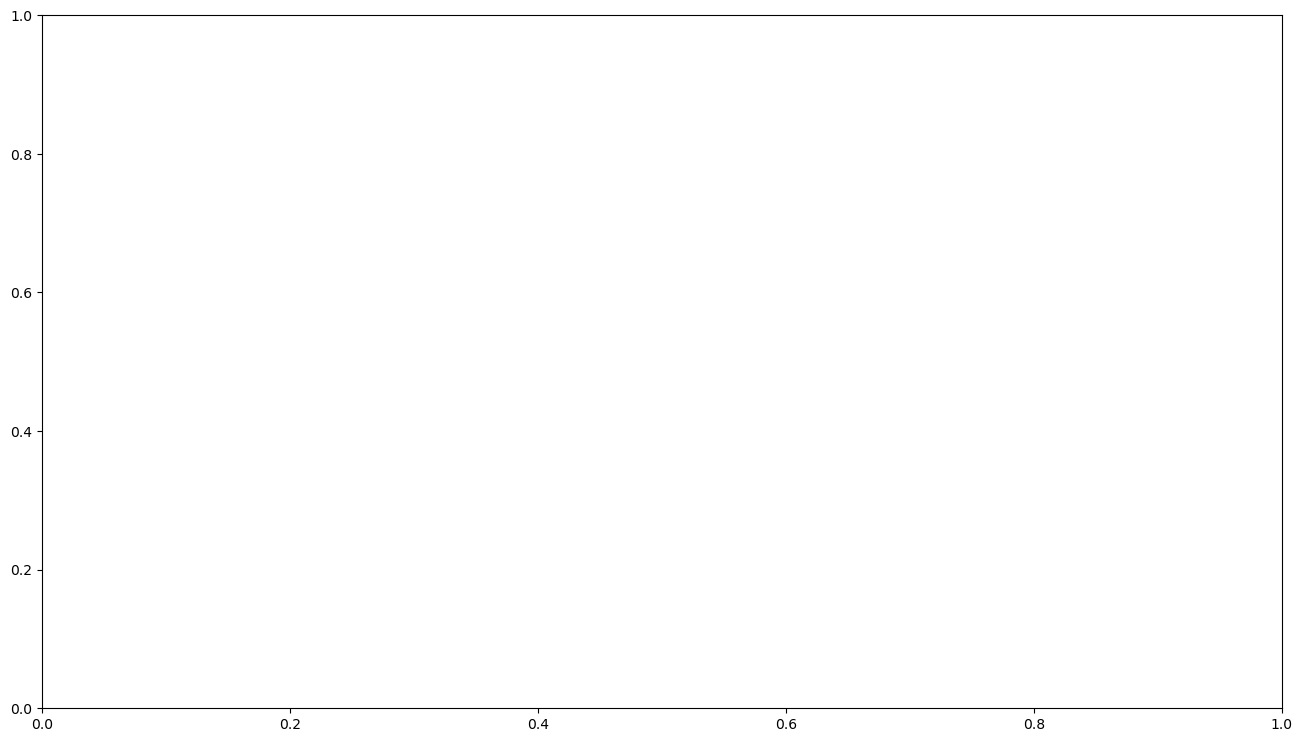

In [60]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR',ax=ax)
plt.show();

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

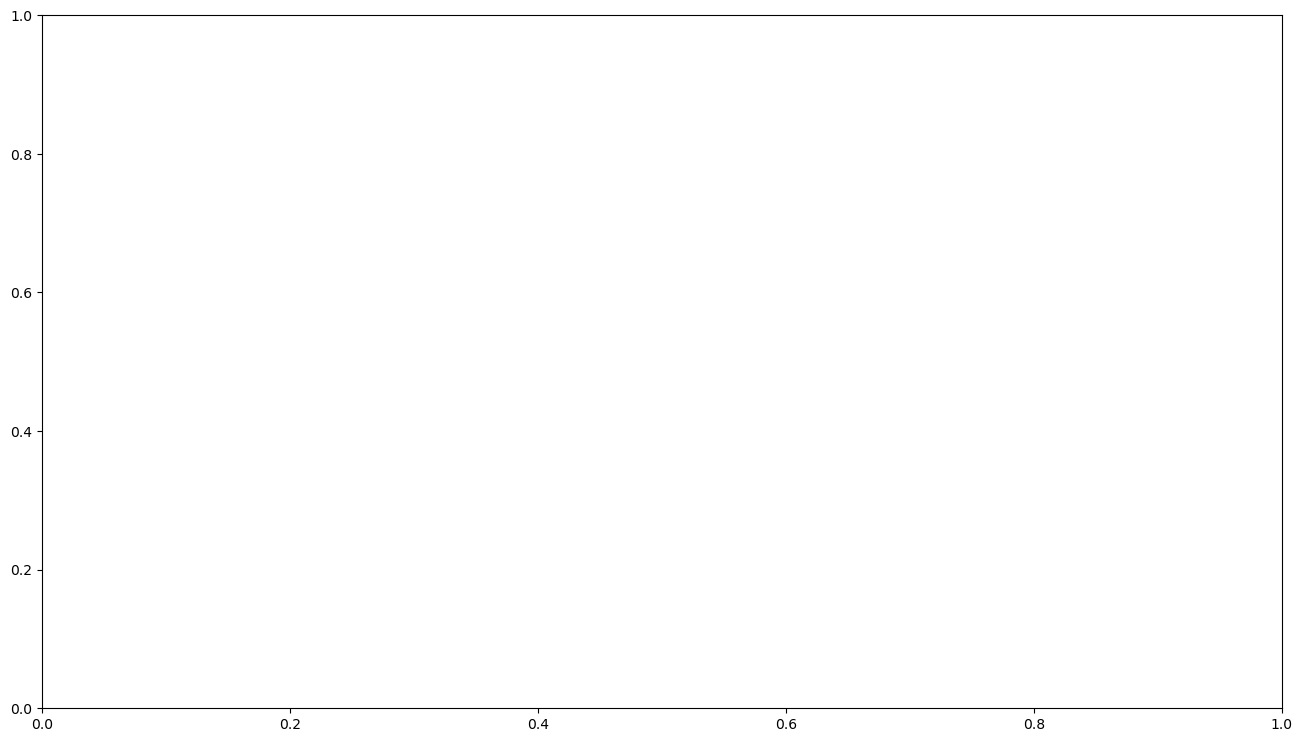

In [61]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR', num_trees=1,ax=ax)
plt.show(); #visualization of another tree

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

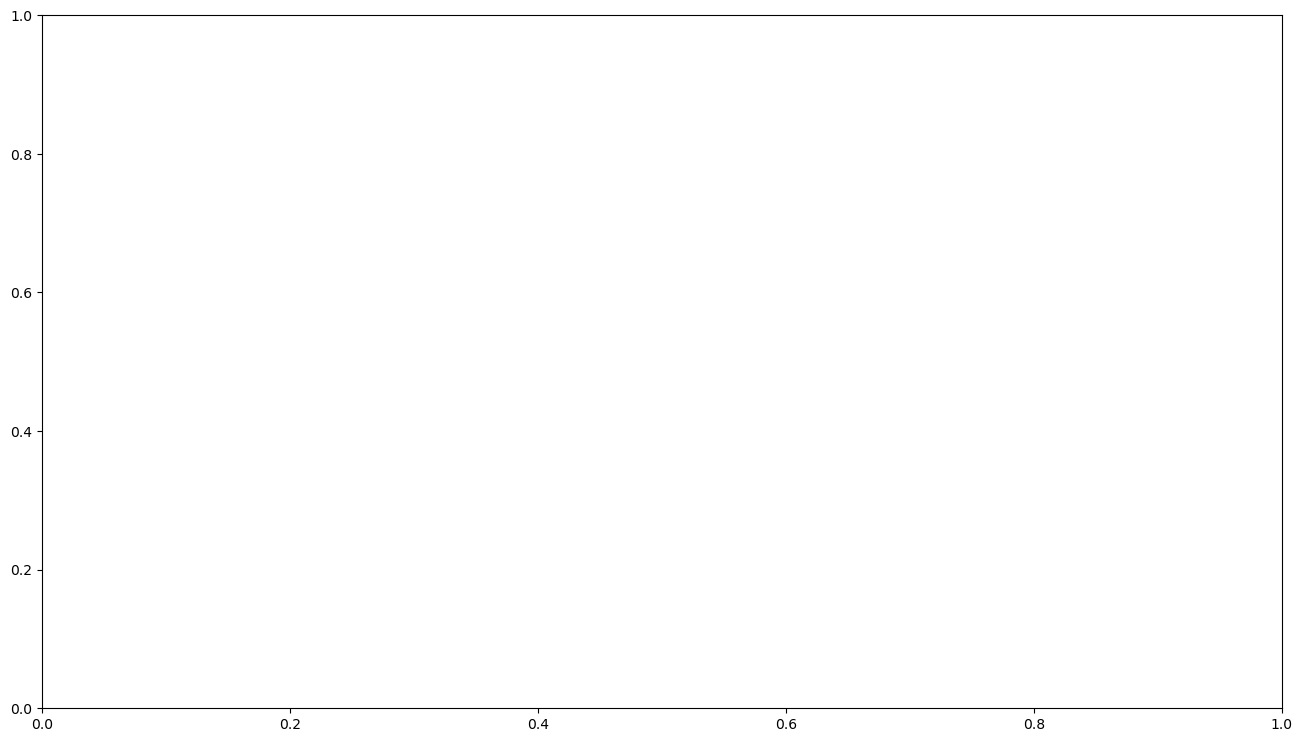

In [62]:
fig, ax = plt.subplots(figsize=(16, 9))
plot_tree(model, rankdir='LR', num_trees=19,ax=ax)
plt.show(); #visualization of another tree

In [63]:
trees = model.get_booster().get_dump()

print(trees[0])

0:[Promo<0.107919127] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<-0.508807302] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<1.65764904] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<-0.427125275] yes=9,no=10,missing=9
			9:[CompetitionDistance<-0.445225298] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<1.70107782] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<-0.556884944] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<1.70107782] yes=13,no=14,missing=13
			13:[CompetitionDistance<-0.520873904] yes=27,no=28,missing=27
				27:

# Feature importance

In [64]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

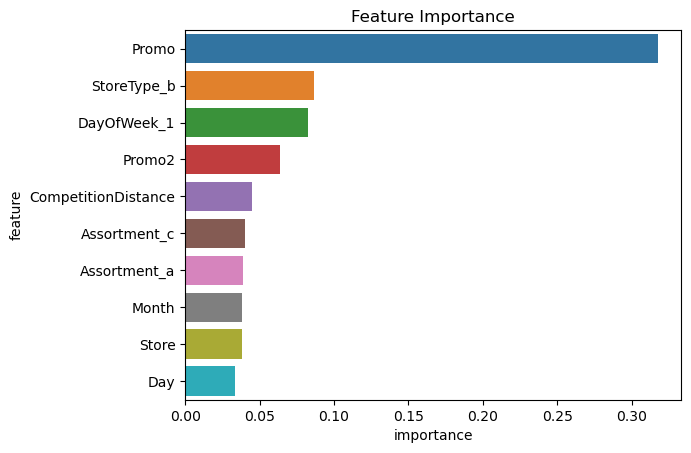

In [65]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');